## PZAD 21.10.2015
### Vladimir Sazontyev

In [3]:
%matplotlib inline 
from data_processing import *
import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor #not yet tried
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import numpy as np
import pylab 
import neurolab as nl
import sklearn_pandas as sk_pd
import theano
import matplotlib.pyplot as plt 
import seaborn as sns

from pylearn2.models import mlp
from pylearn2.training_algorithms import sgd,bgd
from pylearn2.termination_criteria import EpochCounter
from pylearn2.datasets.dense_design_matrix import DenseDesignMatrix
from random import randint
from subprocess import Popen
import os
import theano.tensor as T
import ast
import re
# import seaborn as sns
import math
import xgboost as xgb

In [5]:
train_set = pd.read_table('./data/train.csv',sep=',',low_memory=False)
train_set['Date'] = train_set['Date'].astype("datetime64")
test_set = pd.read_table('./data/test.csv',sep=',',low_memory=False)
test_set['Date'] = test_set['Date'].astype("datetime64")

In [6]:
train_set.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [7]:
print "Amount of store ids in test_set",
print len(set(test_set['Store']))
print "Amount of store ids in train_set",
print len(set(train_set['Store']))
print "Amount of store ids that are in train_set, but not represented in test_set",
print len(set(train_set['Store']) - set(test_set['Store']))

Amount of store ids in test_set 856
Amount of store ids in train_set 1115
Amount of store ids that are in train_set, but not represented in test_set 259


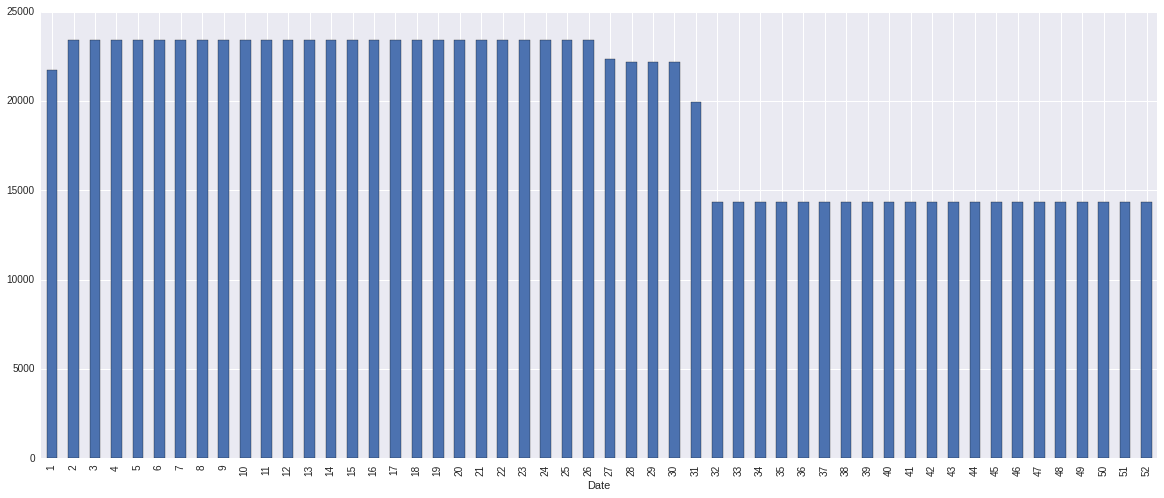

In [8]:
pylab.rcParams['figure.figsize'] = (20.0, 8.0)
train_set['Store'].groupby(train_set['Date'].dt.week).count().plot(kind="bar");

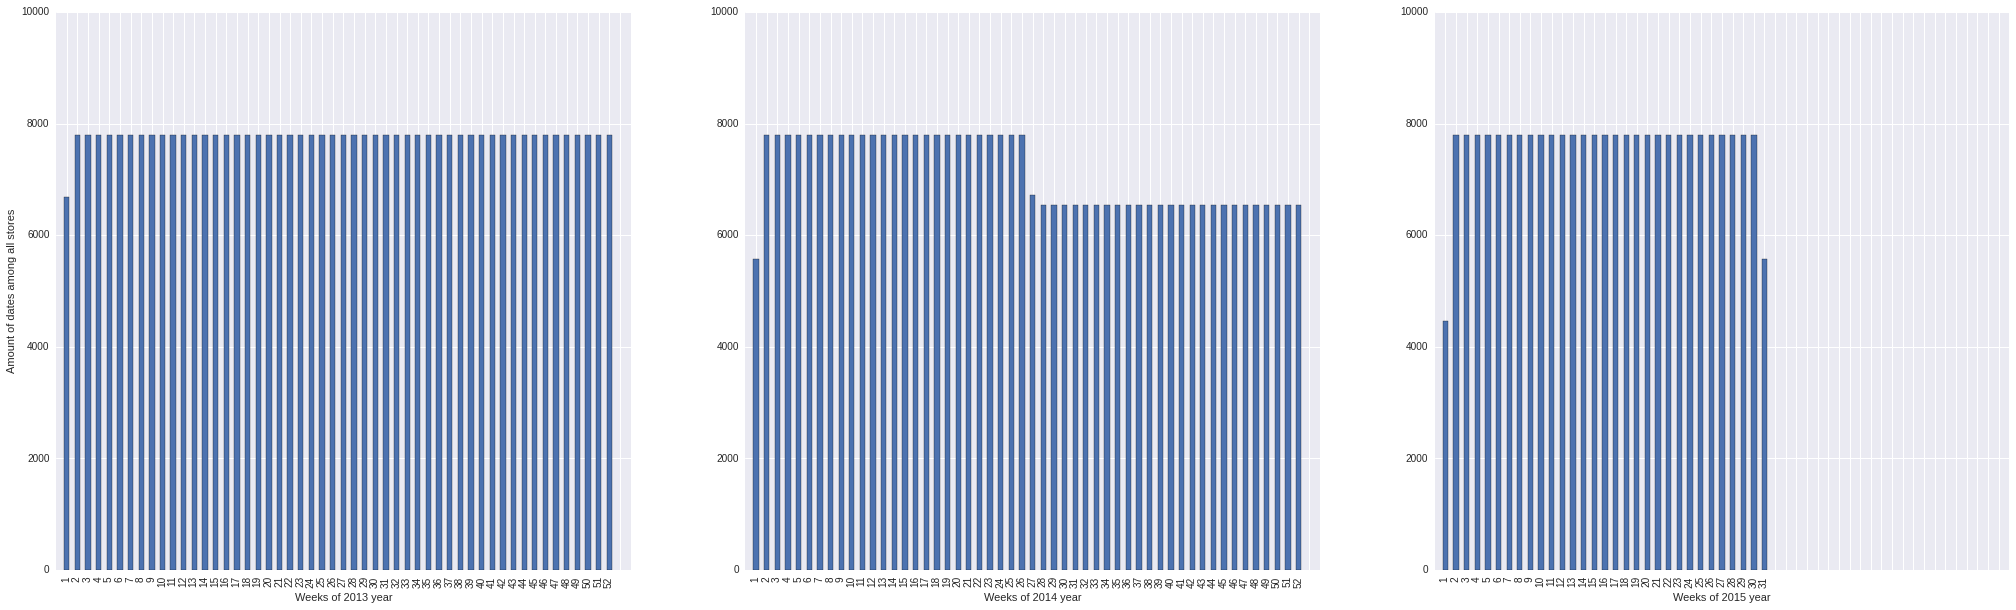

In [9]:
train_set['Week']=train_set['Date'].dt.week
train_set['Year']=train_set['Date'].dt.year
test_set['Week']=test_set['Date'].dt.week
test_set['Year']=test_set['Date'].dt.year
fig, axs = plt.subplots(1,3,figsize=(35.0, 10.0),subplot_kw={'ylim': (0,10000)})
max_val=53
start_point = -1
position_offset = 0.5
x_ticks=range(0,max_val+1)
train_set['Store'].loc[train_set['Year'] == 2013].loc[train_set['Date']<'2013-12-30'].groupby(train_set['Date'].dt.week).count().plot(kind="bar",xticks=x_ticks,ax=axs[0],sharex=True,position=position_offset);
axs[0].set_xlabel('Weeks of 2013 year')
axs[0].set_ylabel('Amount of dates among all stores')
axs[0].set_xlim((start_point, max_val));
train_set['Store'].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29'].groupby(train_set['Date'].dt.week).count().plot(kind="bar",xticks=x_ticks,ax=axs[1],sharex=True,position=position_offset);
axs[1].set_xlabel('Weeks of 2014 year')
axs[1].set_xlim((start_point, max_val));
train_set['Store'].loc[train_set['Year'] == 2015].groupby(train_set['Date'].dt.week).count().plot(kind="bar",xticks=x_ticks,ax=axs[2],sharex=True,position=position_offset);
axs[2].set_xlabel('Weeks of 2015 year')
axs[2].set_xlim((start_point, max_val));

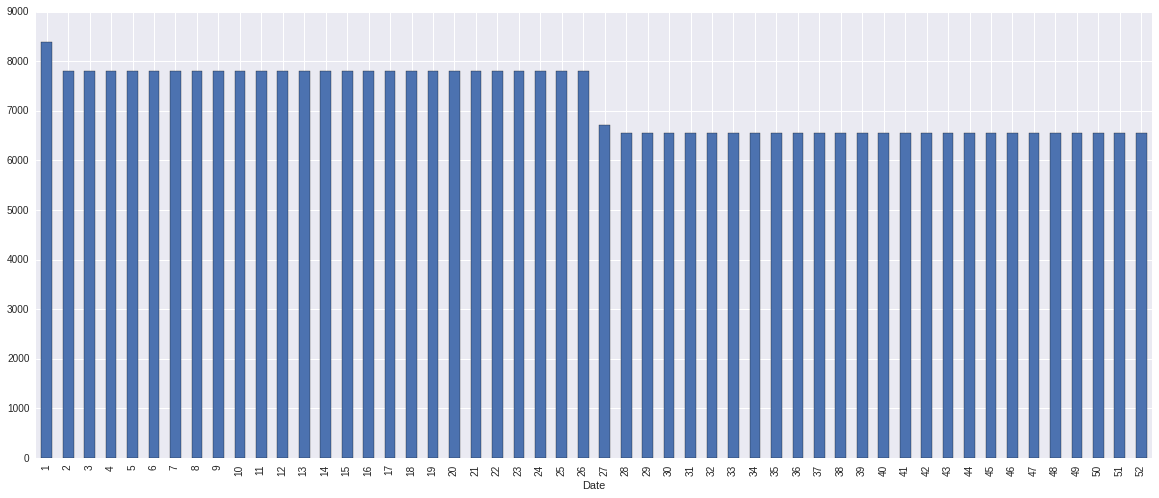

In [10]:
train_set['Store'].loc[train_set['Year'] == 2014].groupby(train_set['Date'].dt.week).count().plot(kind="bar",sharex=True);

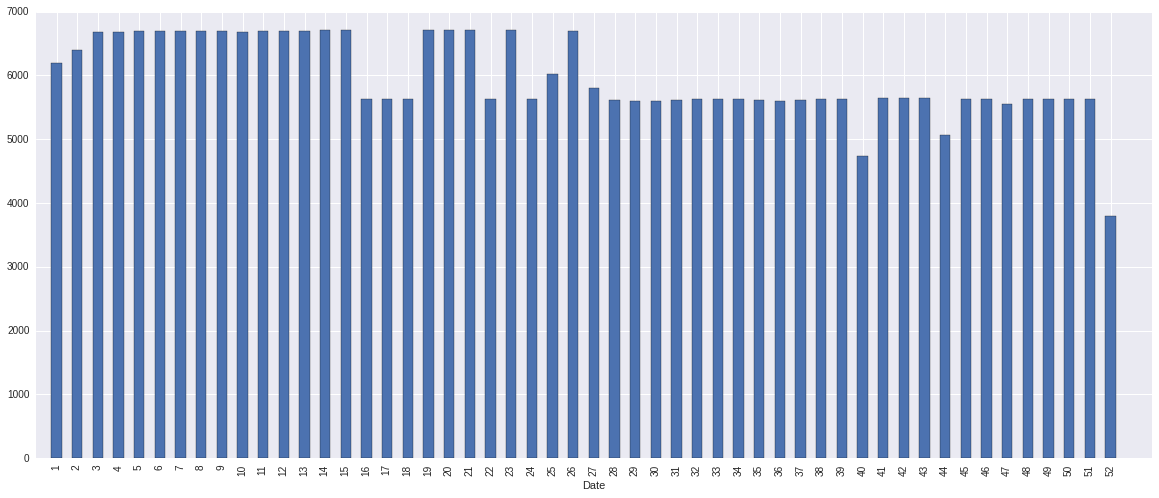

In [11]:
position_offset=0.5
max_val=53
start_point = -1
axs = train_set['Store'].loc[train_set['Year'] == 2014].loc[train_set['Open'] == 1].groupby(train_set['Date'].dt.week).count().plot(kind="bar",sharex=True,position=position_offset);
axs.set_xlim((start_point, max_val));

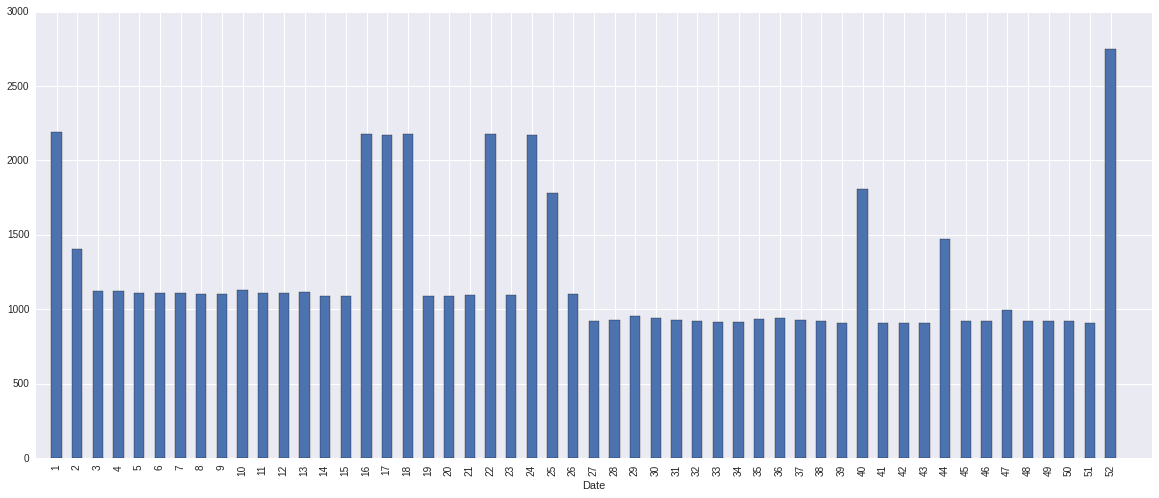

In [12]:
position_offset=0.5
max_val=53
start_point = -1
axs = train_set['Store'].loc[train_set['Year'] == 2014].loc[train_set['Open'] == 0].groupby(train_set['Date'].dt.week).count().plot(kind="bar",sharex=True);
axs.set_xlim((start_point, max_val));

In [13]:
def not_in(df0,df1):
    set_test_set = set(df1['Store'])
    res = []
    for i in df0['Store']:
        res += [i not in set_test_set]
    return res

def that_in(df0,df1):
    set_test_set = set(df1['Store'])
    res = []
    for i in df0['Store']:
        res += [i in set_test_set]
    return res

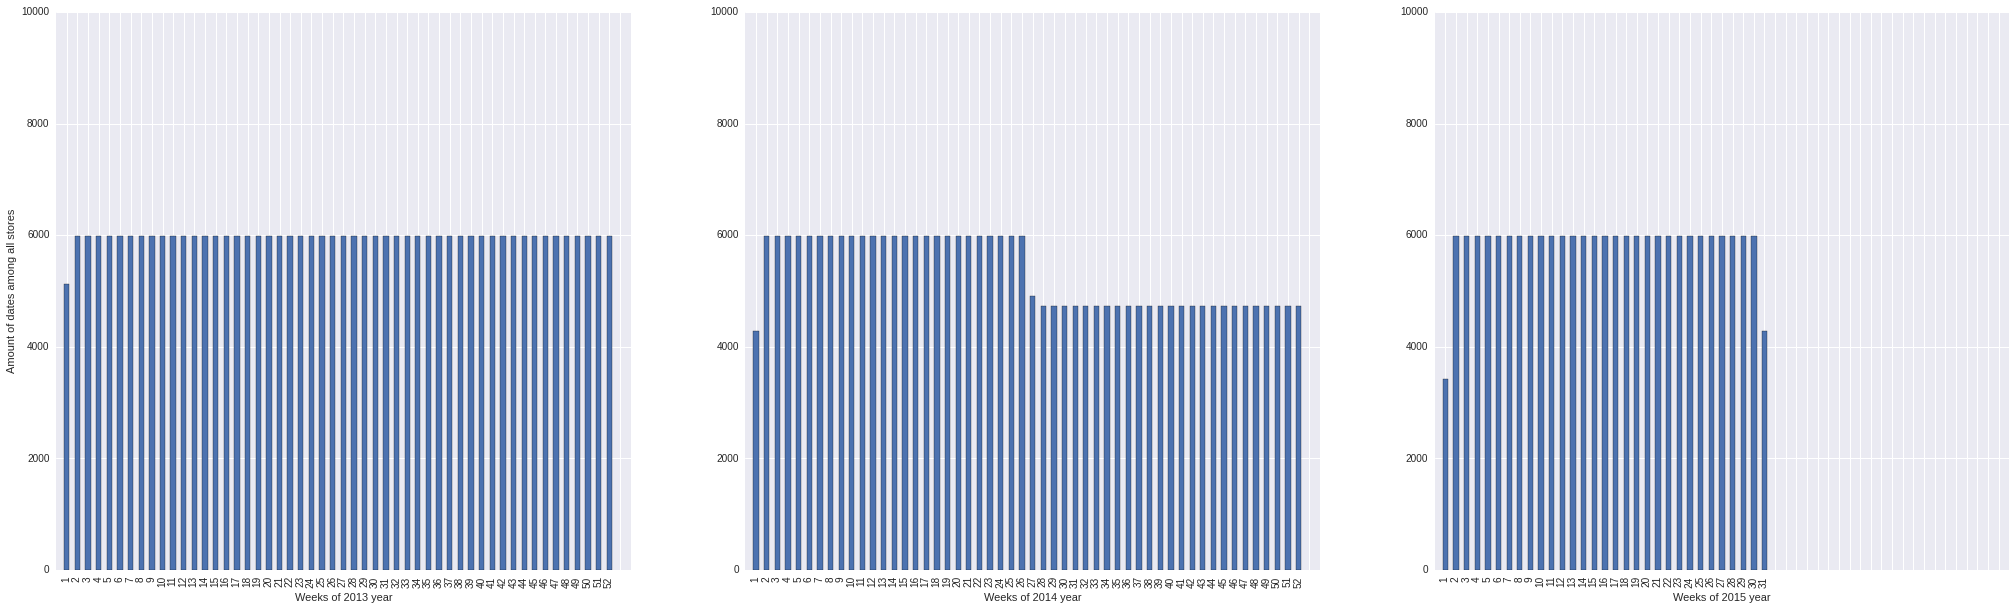

In [14]:
train_set['Week']=train_set['Date'].dt.week
train_set['Year']=train_set['Date'].dt.year
test_set['Week']=test_set['Date'].dt.week
test_set['Year']=test_set['Date'].dt.year
fig, axs = plt.subplots(1,3,figsize=(35.0, 10.0),subplot_kw={'ylim': (0,10000)})
max_val=53
start_point = -1
position_offset = 0.5
x_ticks=range(0,max_val+1)
train_set['Store'].loc[that_in(train_set,test_set)].loc[train_set['Year'] == 2013].loc[train_set['Date']<'2013-12-30'].groupby(train_set['Date'].dt.week).count().plot(kind="bar",xticks=x_ticks,ax=axs[0],sharex=True,position=position_offset);
axs[0].set_xlabel('Weeks of 2013 year')
axs[0].set_ylabel('Amount of dates among all stores')
axs[0].set_xlim((start_point, max_val));
train_set['Store'].loc[that_in(train_set,test_set)].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29'].groupby(train_set['Date'].dt.week).count().plot(kind="bar",xticks=x_ticks,ax=axs[1],sharex=True,position=position_offset);
axs[1].set_xlabel('Weeks of 2014 year')
axs[1].set_xlim((start_point, max_val));
train_set['Store'].loc[that_in(train_set,test_set)].loc[train_set['Year'] == 2015].groupby(train_set['Date'].dt.week).count().plot(kind="bar",xticks=x_ticks,ax=axs[2],sharex=True,position=position_offset);
axs[2].set_xlabel('Weeks of 2015 year')
axs[2].set_xlim((start_point, max_val));

In [15]:
print  set(train_set['Store'].loc[not_in(train_set,test_set)].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29'].groupby(train_set['Date'].dt.week).count())

set([1813, 1295])


In [16]:
store_ids_at_week_28 = set(train_set['Store'].loc[that_in(train_set,test_set)].loc[train_set['Week'] == 28].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29'])
print len(store_ids_at_week_28)

676


In [17]:
store_ids_at_week_25 = set(train_set['Store'].loc[that_in(train_set,test_set)].loc[train_set['Week'] == 25].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29'])
print len(store_ids_at_week_25)

856


In [18]:
missing_store_ids = store_ids_at_week_25-store_ids_at_week_28
print len(missing_store_ids)

180


In [19]:
store_ids_at_week_28_overall = set(train_set['Store'].loc[train_set['Week'] == 28].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29'])
store_ids_at_week_25_overall = set(train_set['Store'].loc[train_set['Week'] == 25].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29'])
missing_store_ids_overall = store_ids_at_week_25_overall-store_ids_at_week_28_overall
print len(missing_store_ids_overall)

180


In [20]:
def in_set(df0,set_list):
    res = []
    for i in df0['Store']:
        res += [i in set_list]
    return res

In [21]:
train_set.loc[in_set(train_set,missing_store_ids)].shape[0]

136440

In [22]:
train_set.loc[in_set(train_set,missing_store_ids)].loc[train_set['Week'] == 25].loc[train_set['Year'] == 2014].loc[train_set['Date']<'2014-12-29']#.loc[train_set['Open'] == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Week,Year
417352,13,7,2014-06-22,0,0,0,0,0,0,25,2014
417359,20,7,2014-06-22,0,0,0,0,0,0,25,2014
417361,22,7,2014-06-22,0,0,0,0,0,0,25,2014
417371,32,7,2014-06-22,0,0,0,0,0,0,25,2014
417375,36,7,2014-06-22,0,0,0,0,0,0,25,2014
417380,41,7,2014-06-22,0,0,0,0,0,0,25,2014
417385,46,7,2014-06-22,0,0,0,0,0,0,25,2014
417390,51,7,2014-06-22,0,0,0,0,0,0,25,2014
417391,52,7,2014-06-22,0,0,0,0,0,0,25,2014
417397,58,7,2014-06-22,0,0,0,0,0,0,25,2014


###Part 2, other plots

In [23]:
train_set.columns


Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'Week', u'Year'],
      dtype='object')

In [24]:
test_set.columns

Index([u'Id', u'Store', u'DayOfWeek', u'Date', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'Week', u'Year'],
      dtype='object')

/home/cloudera/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



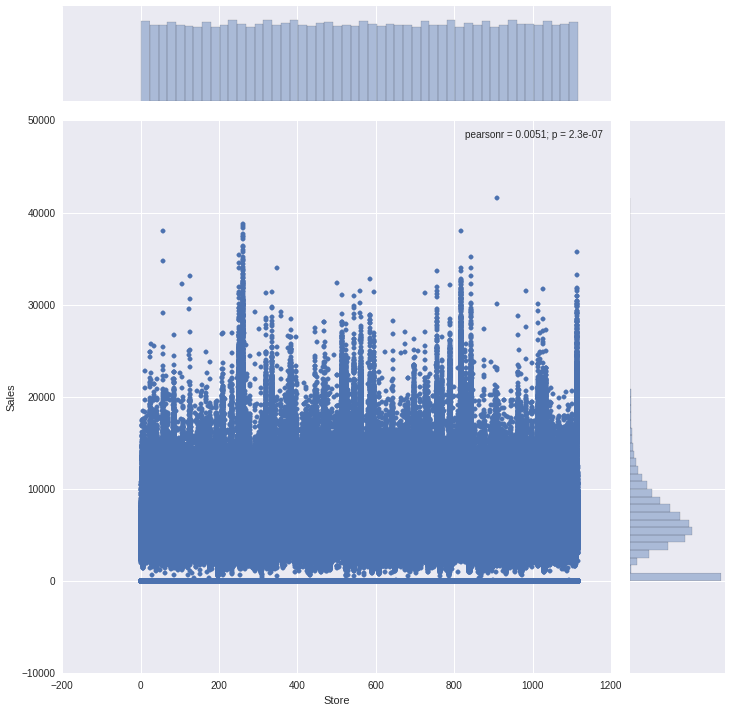

In [25]:
sns.jointplot('Store', 'Sales', data=train_set,size=10)

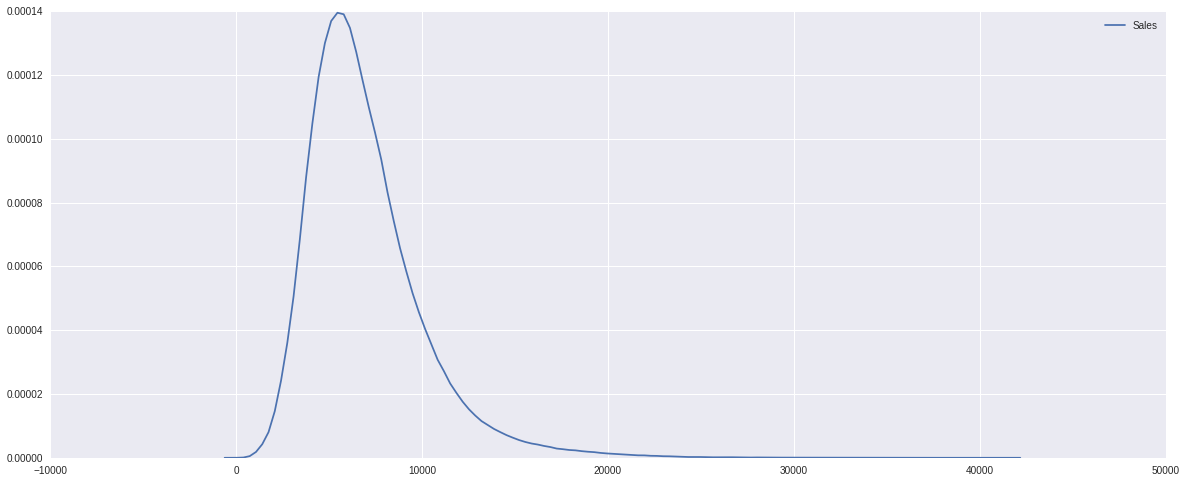

In [26]:
sns.kdeplot(train_set['Sales'])

In [27]:
train_set['Store_sales_mean'] = train_set['Sales'].groupby(train_set['Store']).mean()

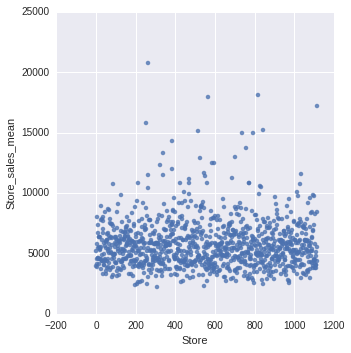

In [30]:
sns.lmplot('Store', 'Store_sales_mean', data=train_set, fit_reg=False);

In [ ]:
train_sorted = train_set.sort_values(by='Store_sales_mean')
sns.lmplot('Store', 'Store_sales_mean', data=train_sorted, fit_reg=False).set(xticks=train_sorted['Store']);

In [51]:
train_set['Sales'].loc[train_set['Store'] == 1].describe()

count      942.000000
mean      4122.991507
std       2363.628674
min          0.000000
25%       2806.750000
50%       4395.500000
75%       5804.500000
max      10682.000000
Name: Sales, dtype: float64

In [52]:
train_set['Sales'].loc[train_set['Store'] == 2].describe()[1]

4122.9915074309974

In [55]:
def mean_overall(df):
    mean_overall
    res = []
    return res

In [56]:
mean_overall(train_set)

[]

In [ ]:
Supplementary things.

In [25]:
#train_set['Date'].dt.week

In [27]:
[datetime(2013, 1, 1),
 datetime(2013,2,28)]

[datetime.datetime(2013, 1, 1, 0, 0), datetime.datetime(2013, 2, 28, 0, 0)]

In [ ]:
print train_set[['Store','Date']].loc[train_set['Store']==2].loc[train_set['Week'] == 1].groupby(train_set['Date'].dt.year).count()

In [26]:
dir(train_set['Date'].dt)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_add_delegate_accessors',
 '_constructor',
 '_delegate_method',
 '_delegate_property_get',
 '_delegate_property_set',
 '_local_dir',
 '_reset_cache',
 'date',
 'day',
 'dayofweek',
 'dayofyear',
 'freq',
 'hour',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'microsecond',
 'minute',
 'month',
 'nanosecond',
 'quarter',
 'second',
 'time',
 'to_period',
 'to_pydatetime',
 'tz',
 'tz_convert',
 'tz_localize',
 'week',
 'weekday',
 'weekofyear',
 'year']

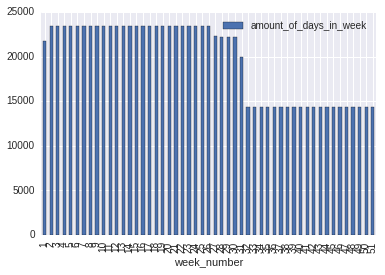

In [22]:
#get days by week and plot
ts=pd.DataFrame()
res=pd.DataFrame(columns=['week_number','amount_of_days_in_week'])
ts['Week']=train_set['Date'].dt.week
ts = ts.sort_values('Week')
ts.size
cnt = 0
prev_val=-1
for i in ts['Week']:
    if (prev_val != i):
        if (prev_val != -1):
            res = res.append(pd.DataFrame({'week_number':[int(prev_val)],
                                    'amount_of_days_in_week':[float(cnt)/prev_val]},))
        prev_val = i
        cnt=i
    else:
        cnt+=i
        
res[['week_number',]] = res[['week_number', ]].astype(int)
res = res.sort_values('week_number')
res = res.set_index(['week_number']);

pylab.rcParams['figure.figsize'] = (6.0, 4.0)
# res.plot(x='week_number',y='amount_of_days_in_week',kind="bar");
res.plot(kind="bar");
# print res